#Run first time only

In [1]:
#@title
#Install the PyDrive wrapper & import libraries.
!pip3 install pydub &> /dev/null
!apt install sox &> /dev/null
!pip3 install ffmpeg-python &> /dev/null
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from scipy.io.wavfile import write

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# file_id = '1wWWsPgyI2I8X3x6FQSj8xRn1ksrsRw46'
file_id = '1mPChOrEGMXT7kuIFHSr5DiCe5Vks9RDf'
downloaded = drive.CreateFile({'id':file_id})
downloaded.FetchMetadata(fetch_all=True)
downloaded.GetContentFile(downloaded.metadata['title'])

!unzip -o /content/noise-reducer-ml-2.zip &> /dev/null
!rm /content/noise-reducer-ml-2.zip

#Run for each audio

##Upload audio here

Try to upload audio with wav format. Other formats may get error.

In [2]:
from google.colab import files
%cd /content
uploaded = files.upload()

/content


Saving concert.wav to concert.wav


##Or record a audio

In [ ]:
#@title
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg
import tensorflow as tf

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [ ]:
audio, sr = get_audio()
Audio(audio, rate=sr) 
write("/content/noisy.wav", sr, audio.astype(np.int16))

##Just run

In [3]:
#@title
%cd '/content/noise-reducer-ml/denoiser-inverse/denoiser'


import sys
import os
from pydub import AudioSegment

py_file_location = "./denoiser"
sys.path.append(os.path.abspath(py_file_location))
import demucs
from enhance import pred
from stft_loss import loss_func

import glob
files = []
for file in glob.glob("/content/*.*"):
    files.append(file)
exten = os.path.splitext(files[0])[1][1:]
# print(exten)
if len(files) != 0:
  if exten != 'wav':
    sound = AudioSegment.from_file(files[0], exten)
    sound.export('/content/noisy.wav', format="wav")
  else:
    !mv /content/*.wav /content/noisy.wav
  # !apt install sox &> /dev/null
  !sox /content/noisy.wav -r 48000 /content/noisyf.wav 
  noisy, estimated = pred(model_path='/content/noise-reducer-ml/checkpoint_epoch-198_loss-0.002579.h5',noisy_file_path='/content/noisyf.wav')
  !cd /content/
  !rm /content/*.*
else:
  print("No audio found")
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import librosa
import IPython.display as ipd
from IPython.display import Audio

/content/noise-reducer-ml/denoiser-inverse/denoiser
sox WARN rate: rate clipped 32 samples; decrease volume?
sox WARN dither: dither clipped 29 samples; decrease volume?


##Outputs

In [4]:
x = noisy
y = estimated
print("This is the noisy audio\n")
Audio(x.numpy(), rate=48000) 

Output hidden; open in https://colab.research.google.com to view.

In [5]:
print("This is the enhanced audio\n")
# print(y)
Audio(y.numpy(), rate=48000)

Output hidden; open in https://colab.research.google.com to view.

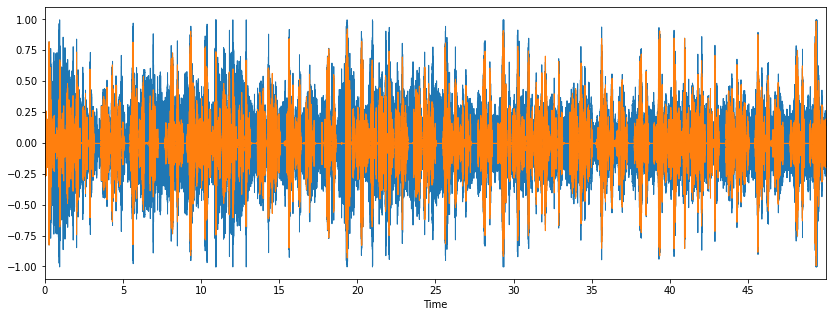

In [6]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(noisy.numpy(), sr=48000)
librosa.display.waveplot(estimated.numpy(), sr=48000)
import scipy.io.wavfile as wavfile